In [64]:
import pandas as pd
train= pd.read_csv("./Data/train_data.csv")
test= pd.read_csv("./Data/test_data.csv")

#import numpy as np
df_train = pd.concat([train,test])



In [65]:
# run only first time.

#! pip install keras
#! pip install tensorflow
#! pip install tensorflow_addons
#! pip install nltk
#! pip install textblob

#nltk.download('wordnet')
#nltk.download('stopwords')

In [66]:
import nltk
import pandas as pd
from textblob import Word
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
import tensorflow as tf
import numpy as np

df_train = df_train[['FFT answer','Comment sentiment']]
df_train = df_train[df_train['Comment sentiment'].isna()==False]

conditions = [df_train['Comment sentiment'] >= 5,df_train['Comment sentiment'] <= 2,]
values = [1,  0]
df_train['rating'] = np.select(conditions, values)

#Pre-Processing the text
def cleaning(df, stop_words):
    df_train['Review'] = df_train['FFT answer'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
    # Replacing the digits/numbers
    df['Review'] = df['Review'].str.replace('d', '')
    # Removing stop words
    df['Review'] = df['Review'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['Review'] = df['Review'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    return df

stop_words = stopwords.words('english')


data_cleaned = cleaning(df_train, stop_words)

#Generating Embeddings using tokenizer
tokenizer = Tokenizer(num_words=50, split=' ')
tokenizer.fit_on_texts(data_cleaned['Review'].values)
X = tokenizer.texts_to_sequences(data_cleaned['Review'].values)
X = pad_sequences(X)

X= tf.keras.utils.normalize(X, axis=-1, order=2)

# one hot encoding on target
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y= df_train["rating"].values
Y= enc.fit_transform(Y.reshape(-1,1)).toarray()

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=5)


In [67]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.77151675, 0.15430335,
        0.6172134 ],
       [0.        , 0.        , 0.        , ..., 0.18653341, 0.44768017,
        0.14922672],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.08513422, 0.25540267,
        0.21283555],
       [0.        , 0.        , 0.        , ..., 0.09467621, 0.94676214,
        0.30769769]])

In [68]:
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [69]:
#Model Building
import keras
from keras import optimizers
import tensorflow as tf
import tensorflow_addons as tfa

model = Sequential()
model.add(Embedding(50, 80, input_length = X.shape[1]))
model.add(LSTM(128))
model.add(Dense(128, activation='LeakyReLU'))
model.add(Dense(2, activation='sigmoid'))

adam = tf.optimizers.Adam(lr=0.1)
model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics = ['accuracy',tfa.metrics.F1Score(num_classes=2)])
print(model.summary())

#Model Training
history=model.fit(X_train, Y_train, epochs = 20, batch_size=32, verbose =1,validation_split=0.2)

#Model Testing
score, acc, f1_score = model.evaluate(X_test,Y_test)

print("loss on test set:",score)
print("accuracy on test set",acc)
print("f1_score on test set",f1_score)



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 55, 80)            4000      
                                                                 
 lstm_7 (LSTM)               (None, 128)               107008    
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 2)                 258       
                                                                 
Total params: 127,778
Trainable params: 127,778
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20


/usr/local/python/3.10.13/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


125/125 [==============================] - 8s 57ms/step - loss: 1.6877 - accuracy: 0.9188 - f1_score: 0.5107 - val_loss: 0.2769 - val_accuracy: 0.9608 - val_f1_score: 0.4900
Epoch 2/20
125/125 [==============================] - 7s 56ms/step - loss: 0.2649 - accuracy: 0.9497 - f1_score: 0.4969 - val_loss: 0.2345 - val_accuracy: 0.9608 - val_f1_score: 0.4900
Epoch 3/20
125/125 [==============================] - 7s 53ms/step - loss: 0.1905 - accuracy: 0.9585 - f1_score: 0.4894 - val_loss: 0.1863 - val_accuracy: 0.9608 - val_f1_score: 0.4900
Epoch 4/20
125/125 [==============================] - 7s 53ms/step - loss: 0.1842 - accuracy: 0.9585 - f1_score: 0.4894 - val_loss: 0.1703 - val_accuracy: 0.9608 - val_f1_score: 0.4900
Epoch 5/20
125/125 [==============================] - 7s 52ms/step - loss: 0.1792 - accuracy: 0.9585 - f1_score: 0.4894 - val_loss: 0.1726 - val_accuracy: 0.9608 - val_f1_score: 0.4900
Epoch 6/20
125/125 [==============================] - 7s 55ms/step - loss: 0.1792 - ac

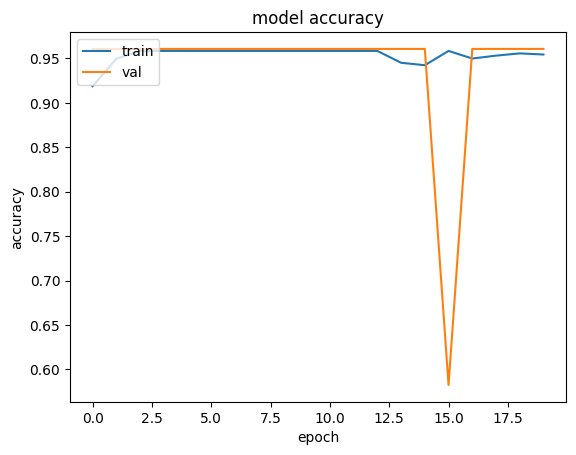

In [70]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

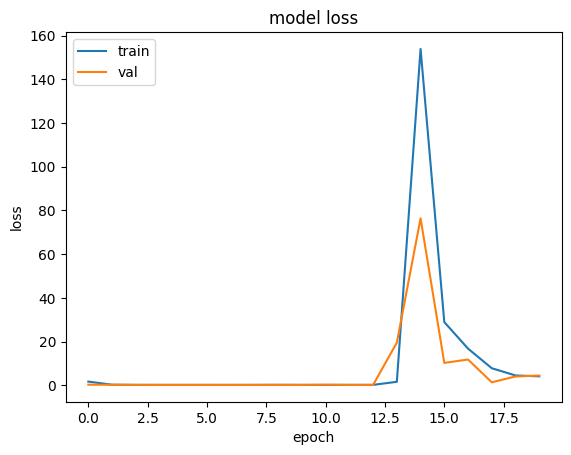

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
#model.save('model.h5')